### Importação de Bibliotecas

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extração e Transformação de Dados
from facebook_business.api import FacebookAdsApi
from facebook_business.adobjects.adaccount import AdAccount
from facebook_business.exceptions import FacebookRequestError
import os
import logging
import time
from typing import Dict, Optional

# Modelos e métricas de avaliação
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ignorando avisos
import warnings
warnings.filterwarnings("ignore")

### Pipeline de Extração e Transformação

Será executado um **pipeline de extração e transformação de dados**, desenvolvido para coletar informações por meio da API do Meta. Este pipeline emprega **variáveis constantes** essenciais para o projeto, garantindo a consistência e a integridade dos dados extraídos.

Embora o pipeline seja arquitetado para a **extração assíncrona de dados de múltiplas contas**, para os propósitos deste projeto, a extração será **restrita aos dados de uma única conta**. Esta abordagem visa a centralização e otimização da análise para o escopo definido.

### Detalhes da Extração de Dados

A extração de dados do Meta Ads será focada nas seguintes métricas, essenciais para a nossa análise:

* **`campaign_name`**: Nome da campanha.
* **`spend`**: Gasto total na campanha.
* **`inline_link_clicks`**: Número de cliques no link interno.
* **`reach`**: Alcance único da campanha.
* **`impressions`**: Número total de impressões.
* **`ctr`**: Taxa de cliques (Click-Through Rate).
* **`cpc`**: Custo por clique (Cost Per Click).

A estrutura hierárquica do Meta Ads, que se organiza em Campanha (nível superior), Conjuntos de Anúncios (segmentação) e Anúncios (nível mais granular), direciona nossa estratégia de extração. Para este projeto, os dados serão extraídos a partir do **nível de Conjunto de Anúncios (`adset`)**.

As configurações de extração são as seguintes:

* **`level`**: `adset` (conjunto de anúncios)
* **`date_preset`**: `last_90d` (últimos 90 dias)
* **`time_increment`**: `1` (incremento diário, garantindo granularidade)
* **`limit`**: `2000` (limite de 2000 dados para assegurar uma extração completa)

In [10]:
# Configuração do logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Bloco para carregar credenciais com segurança
try:
    import my_secrets as credential
except ImportError:
    logging.error("Arquivo de credenciais 'my_secrets.py' não encontrado.")
    exit()

# --- ETAPA 1: CONFIGURAÇÃO ---

def inicializar_api():
    """Inicializa a API do Facebook. Encerra o script em caso de falha."""
    try:
        FacebookAdsApi.init(
            app_id=credential.APP_ID,
            app_secret=credential.APP_SECRET,
            access_token=credential.ACCESS_TOKEN
        )
        logging.info("API do Meta Ads inicializada com sucesso!")
        return True
    except Exception as e:
        logging.critical(f"Erro fatal ao inicializar a API: {e}")
        return False

# Definição dos campos e parâmetros (constantes)
INSIGHT_FIELDS = [
    'campaign_name',
    'spend',
    'inline_link_clicks',
    'reach',
    'impressions',
    'ctr',
    'cpc',
]

INSIGHT_PARAMS = {
    'level': 'adset',
    'date_preset': 'last_90d',
    'time_increment': '1',
    'limit': 2000
}

# --- ETAPA 2: EXTRAÇÃO ASSÍNCRONA ---

def extrair_insights_de_multiplas_contas(mapa_clientes: Dict[str, str]) -> Optional[pd.DataFrame]:
    """
    Inicia requisições assíncronas para buscar insights de múltiplas contas,
    aguarda a conclusão e consolida os resultados em um único DataFrame.
    """
    jobs = []
    logging.info(f"Iniciando {len(mapa_clientes)} jobs de extração assíncrona.")

    for nome_cliente, ad_account_id in mapa_clientes.items():
        try:
            account = AdAccount(fbid=ad_account_id)
            async_job = account.get_insights(fields=INSIGHT_FIELDS, params=INSIGHT_PARAMS, is_async=True)
            jobs.append({'job': async_job, 'nome_cliente': nome_cliente})
            logging.info(f"--> Job para '{nome_cliente}' iniciado.")
        except FacebookRequestError as e:
            logging.error(f"Erro ao iniciar job para '{nome_cliente}': {e.api_error_message()}")

    insights_por_cliente = []
    active_jobs = list(jobs)
    while active_jobs:
        time.sleep(5) 
        remaining_jobs = []
        for job_info in active_jobs:
            job = job_info['job']
            nome_cliente = job_info['nome_cliente']
            
            try:
                job.api_get() 
                status = job['async_status']
                
                if status == 'Job Completed':
                    insights_cursor = job.get_result()
                    insights_list = [dict(insight) for insight in insights_cursor]
                    
                    if insights_list:
                        df_cliente = pd.DataFrame(insights_list)
                        df_cliente['nome_cliente'] = nome_cliente
                        insights_por_cliente.append(df_cliente)
                        logging.info(f"  [SUCESSO] Job para '{nome_cliente}' concluído. {len(df_cliente)} registros obtidos.")
                    else:
                        logging.warning(f"  [AVISO] Job para '{nome_cliente}' concluído, mas sem dados.")
                
                elif status in ['Job Failed', 'Job Skipped']:
                    logging.error(f"  [FALHA] Job para '{nome_cliente}' falhou com status: {status}. Causa: {job.get('async_percent_completion', 'N/A')}")
                
                else: 
                    remaining_jobs.append(job_info)
                    
            except FacebookRequestError as e:
                logging.error(f"  [ERRO API] Erro ao verificar status do job para '{nome_cliente}': {e.api_error_message()}")
            except Exception as e:
                logging.error(f"  [ERRO INESPERADO] Ocorreu um erro com o job de '{nome_cliente}': {e}")
        
        active_jobs = remaining_jobs
            
    if not insights_por_cliente:
        logging.warning("Nenhum dado foi extraído de nenhuma conta.")
        return None

    df_consolidado = pd.concat(insights_por_cliente, ignore_index=True)
    logging.info("Todos os dados dos clientes foram consolidados com sucesso.")
    return df_consolidado


# --- ETAPA 3: PÓS-PROCESSAMENTO AVANÇADO ---

def processar_e_salvar(df: pd.DataFrame, caminho_saida: str):
    """
    Realiza a limpeza, transforma a coluna 'actions' e salva o DataFrame final.
    """
    if df is None or df.empty:
        logging.warning("DataFrame vazio. Nada para processar ou salvar.")
        return

    logging.info("Iniciando pós-processamento do DataFrame consolidado...")

    # Conversão de tipos de dados
    cols_to_numeric = [
        'spend', 'inline_link_clicks', 'impressions', 
        'ctr', 'cpc', 'reach'
    ]
    action_cols = [col for col in df.columns if col.startswith('action_')]
    cols_to_numeric.extend(action_cols)

    for col in cols_to_numeric:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    logging.info("Colunas métricas convertidas para formato numérico.")

    # Tratamento de Valores Nulos
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    logging.info("Valores nulos em colunas numéricas preenchidos com 0.")

    string_cols = df.select_dtypes(include='object').columns
    df[string_cols] = df[string_cols].fillna('')
    logging.info("Valores nulos em colunas de texto preenchidos com ''.")

    # Reordenação de colunas para melhor visualização (usando principais constantes)
    primeiras_colunas = [
        'nome_cliente', 'date_start', 'date_stop', 'campaign_name', 
        'adset_name', 'ad_name'
    ]
    primeiras_colunas_existentes = [col for col in primeiras_colunas if col in df.columns]
    outras_colunas = [col for col in df.columns if col not in primeiras_colunas_existentes]
    df = df[primeiras_colunas_existentes + outras_colunas]

    # Salvar o arquivo final em CSV
    try:
        df.to_csv(caminho_saida, index=False, encoding='utf-8-sig')
        logging.info(f"Relatório consolidado e processado salvo em: {caminho_saida}")
    except Exception as e:
        logging.error(f"Não foi possível salvar o arquivo CSV: {e}")

# --- FUNÇÃO PRINCIPAL ---

def main():
    """Função principal que orquestra todo o pipeline."""
    if not inicializar_api():
        return

    ARQUIVO_SAIDA = "relatorio_consolidado_clientes.csv"
    try:
        MAPA_DE_CLIENTES = credential.MAPA_DE_CLIENTES
    except AttributeError:
        logging.error("A variável 'MAPA_DE_CLIENTES' não foi encontrada no seu arquivo 'my_credentials.py'.")
        return

    df_final = extrair_insights_de_multiplas_contas(MAPA_DE_CLIENTES)
    processar_e_salvar(df_final, ARQUIVO_SAIDA)

    logging.info("Pipeline concluído!")

if __name__ == "__main__":
    main()

2025-06-17 10:19:58 - INFO - API do Meta Ads inicializada com sucesso!
2025-06-17 10:19:58 - INFO - Iniciando 1 jobs de extração assíncrona.
2025-06-17 10:19:59 - INFO - --> Job para 'Confidencial' iniciado.
2025-06-17 10:21:03 - INFO -   [SUCESSO] Job para 'Confidencial' concluído. 917 registros obtidos.
2025-06-17 10:21:03 - INFO - Todos os dados dos clientes foram consolidados com sucesso.
2025-06-17 10:21:03 - INFO - Iniciando pós-processamento do DataFrame consolidado...
2025-06-17 10:21:03 - INFO - Colunas métricas convertidas para formato numérico.
2025-06-17 10:21:03 - INFO - Valores nulos em colunas numéricas preenchidos com 0.
2025-06-17 10:21:03 - INFO - Valores nulos em colunas de texto preenchidos com ''.
2025-06-17 10:21:03 - INFO - Relatório consolidado e processado salvo em: relatorio_consolidado_clientes.csv
2025-06-17 10:21:03 - INFO - Pipeline concluído!


In [16]:
df = pd.read_csv('relatorio_consolidado_clientes.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nome_cliente        925 non-null    object 
 1   date_start          925 non-null    object 
 2   date_stop           925 non-null    object 
 3   campaign_name       925 non-null    object 
 4   spend               925 non-null    float64
 5   inline_link_clicks  925 non-null    float64
 6   reach               925 non-null    int64  
 7   impressions         925 non-null    int64  
 8   ctr                 925 non-null    float64
 9   cpc                 925 non-null    float64
 10  account_id          925 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 79.6+ KB


,nome_cliente,date_start,date_stop,campaign_name,spend,inline_link_clicks,reach,impressions,ctr,cpc,account_id
0,Confidencial,2025-03-17,2025-03-17,1. TRÁFEGO IFOOD,19.60,122.0,4127,4508,3.948536,0.110112,981368493179610
1,Confidencial,2025-03-17,2025-03-17,1. TRÁFEGO IFOOD,19.53,140.0,4097,4532,4.214475,0.102251,981368493179610
2,Confidencial,2025-03-17,2025-03-17,5. CONVERSÃO - RESERVAS TAGME,21.51,157.0,1472,2829,6.362672,0.119500,981368493179610
3,Confidencial,2025-03-17,2025-03-17,5. CONVERSÃO - RESERVAS TAGME,21.82,130.0,1608,2681,5.669526,0.143553,981368493179610
4,Confidencial,2025-03-17,2025-03-17,5. CONVERSÃO - RESERVAS TAGME,14.65,51.0,1362,1751,5.082810,0.164607,981368493179610


In [17]:
df.rename(columns={
    'nome_cliente': 'cliente',
    'date_start': 'data inicio',
    'date_end': 'data fim',
    'campaign_name': 'campanha',
    'spend': 'gasto',
    'reach': 'alcance',
    'impressions': 'impressoes',
    'inline_link_clicks': 'numero de cliques'
}, inplace=True)

df['campanha'].groupby(df['campanha']).count().sort_values(ascending=False).head(10)

campanha
5. CONVERSÃO - RESERVAS TAGME                           360
1. TRÁFEGO IFOOD                                        136
3. ALCANCE                                              108
2. TRÁFEGO - VISITA PARA INSTAGRAM                       83
4. ENGAJAMENTO                                           79
Instagram Post                                           33
ENGAJAMENTO WHATSAPP | Encomendas (Páscoa)               25
Publicação do Instagram: RODÍZIO DE FRUTOS DO MAR...     22
Instagram post: PARAÍSO DOS CAMARÕES COM...              13
Instagram post: Venha conhecer o nosso Delicioso...       7
Name: campanha, dtype: int64

### Seleção da Campanha e Definição do Modelo Preditivo

Para otimizar a precisão da nossa análise, focaremos exclusivamente na campanha com **objetivo de conversão via Tagme**. Nosso objetivo é realizar uma **previsão centralizada** dos dados dessa campanha específica.

Para tal, empregaremos um modelo de **regressão linear**, utilizando as variáveis **`gasto`** e **`impressoes`** como *features* para treinar o modelo. O **`numero de cliques`** será a nossa variável alvo, que buscaremos prever com a maior acurácia possível.

Após essa etapa de seleção e definição, prosseguiremos com a implementação e treinamento do modelo de regressão linear para gerar as previsões desejadas.

In [18]:
# --- PREPARAR OS DADOS ---

df_tagme = df[df['campanha'].str.contains('Conversão - Reservas Tagme', case=False, na=False)]
df_modelo = df_tagme[['campanha', 'gasto', 'impressoes', 'numero de cliques']]

# --- DEFININDO FEATURE (X) E ALVO (y) ---

X = df_modelo[['gasto', 'impressoes']]
y = df_modelo['numero de cliques']

# --- DIVIDIR OS DADOS EM TREINO E TESTE ---

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamanho do conjunto de treino (X):", X_treino.shape)
print("Tamanho do conjunto de teste (X):", X_teste.shape)


# --- TREINAR O MODELO ---

modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

print("\nModelo de Regressão Linear treinado com sucesso!")

Tamanho do conjunto de treino (X): (288, 2)
Tamanho do conjunto de teste (X): (72, 2)

Modelo de Regressão Linear treinado com sucesso!


--- Métricas de Avaliação do Modelo ---
Erro Absoluto Médio (MAE): 14.51 cliques
Erro Quadrático Médio (MSE): 439.08
Raiz do Erro Quadrático Médio (RMSE): 20.95 cliques
Coeficiente de Determinação (R²): 0.80


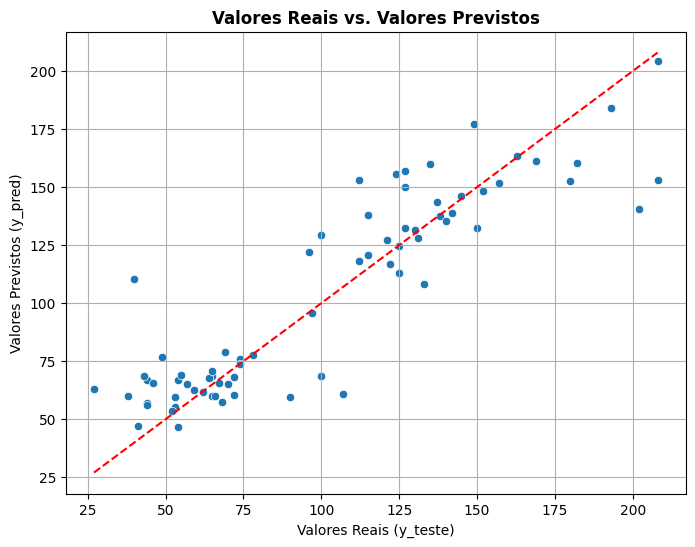

In [19]:
# --- FAZENDO PREVISÕES ---
y_pred = modelo.predict(X_teste)

# --- AVALIANDO O MODELO ---
mae = mean_absolute_error(y_teste, y_pred)
mse = mean_squared_error(y_teste, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_teste, y_pred)

print(f"--- Métricas de Avaliação do Modelo ---")
print(f"Erro Absoluto Médio (MAE): {mae:.2f} cliques")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f} cliques")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

# --- AVALIAÇÃO VISUAL ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_teste, y=y_pred)
plt.xlabel("Valores Reais (y_teste)")
plt.ylabel("Valores Previstos (y_pred)")
plt.title("Valores Reais vs. Valores Previstos", fontweight='bold')

plt.plot([min(y_teste), max(y_teste)], [min(y_teste), max(y_teste)], color='red', linestyle='--')
plt.grid(True)
plt.show()

**➥ Interpretação:** Nosso modelo erra em média entre 14 cliques (MAE) e 18 cliques (RMSE), o que é muito bom se compararmos com a quantidade de valores de treino. Um R2 de 0.85 significa que 85% da variação no número de cliques pode ser explicada pelo nosso modelo (usando gasto e impressões).

**➥ Análise Gráfica da Performance do Modelo:**
A análise do gráfico de dispersão revela uma linearidade proeminente dos dados em relação à linha de referência tracejada. Essa observação indica um ajuste robusto do modelo, demonstrando sua eficácia na predição do valor alvo (y). A proximidade dos pontos de dados à linha de referência corrobora a alta performance preditiva do modelo atual.

Com o objetivo de otimizar ainda mais a precisão das previsões, será implementado um modelo preditivo mais robusto.

In [20]:
from sklearn.ensemble import RandomForestRegressor

# --- TREINANDO O MODELO RANDOM FOREST ---
rf_modelo = RandomForestRegressor(n_estimators=100, 
                                  random_state=42, 
                                  n_jobs=-1)

rf_modelo.fit(X_treino, y_treino)
print("Modelo Random Forest treinado com sucesso!")

# --- AVALIAÇÃO ---
y_pred_rf = rf_modelo.predict(X_teste)

r2_rf = r2_score(y_teste, y_pred_rf)
mae_rf = mean_absolute_error(y_teste, y_pred_rf)

print(f"\n--- Métricas de Avaliação do Random Forest ---")
print(f"Erro Absoluto Médio (MAE): {mae_rf:.2f} cliques")
print(f"Coeficiente de Determinação (R²): {r2_rf:.2f}")

Modelo Random Forest treinado com sucesso!

--- Métricas de Avaliação do Random Forest ---
Erro Absoluto Médio (MAE): 14.85 cliques
Coeficiente de Determinação (R²): 0.83


---

**➥ Avaliação do Modelo Random Forest e Implicações para a Campanha de Conversão:**

A execução do modelo **Random Forest** para a campanha de conversão sugere uma **relação predominantemente linear** entre as variáveis **gasto/impressões** e o **número de cliques**.

Verificou-se que a complexidade ao algoritmo Random Forest não resultou em um ganho significativo no poder preditivo (83%). Isso indica que a **Regressão Linear**, um modelo mais simples e com maior facilidade de interpretação, já se mostra **altamente eficaz e suficiente** para realizar as previsões nesta campanha específica. A escolha por um modelo mais parcimonioso, como a Regressão Linear, otimiza a interpretabilidade sem comprometer a acurácia para este cenário.

---


--- Importância das Features ---
      feature  importancia
0       gasto      0.86051
1  impressoes      0.13949



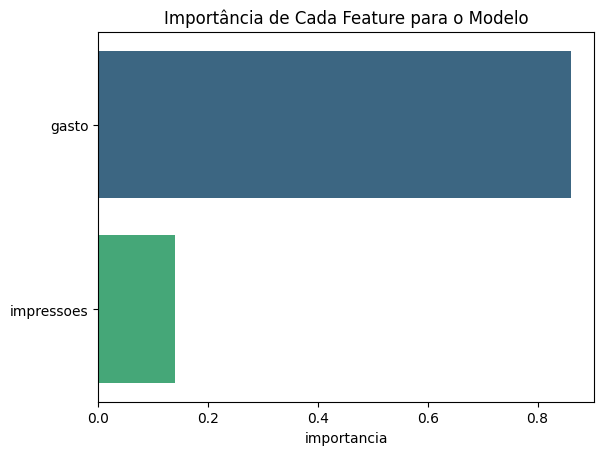

In [21]:
# importância de cada feature do modelo treinado
importancias = rf_modelo.feature_importances_
features = X_treino.columns

# preparando DataFrame 
df_importancias = pd.DataFrame({'feature': features, 'importancia': importancias})
df_importancias = df_importancias.sort_values('importancia', ascending=False)

print("\n--- Importância das Features ---")
print(f"{df_importancias}\n")

# Plot
ax = sns.barplot(x='importancia',
                 y='feature', 
                 data=df_importancias, 
                 palette='viridis', 
                 hue='feature', 
                 legend=False)

plt.title('Importância de Cada Feature para o Modelo')
plt.ylabel('')
plt.show()

Em uma **campanha de conversão**, como a de reservas, o algoritmo da Meta opera de forma mais sofisticada. Ele é projetado para identificar e alcançar usuários com alta probabilidade de realizar a ação desejada. Nesse cenário, o investimento (`gasto`) emerge como a alavanca principal para impulsionar os resultados.

Com base nos dados analisados para esta campanha específica, comprovamos que o **investimento direto é, de fato, o motor principal para a geração de resultados**. Isso ocorre porque, quanto maior o investimento, mais o algoritmo da Meta consegue atuar dentro desse grupo seleto e qualificado de pessoas, gerando cliques de maior valor que se traduzem em conversões efetivas.

### Preparação de Dados para Clusterização K-Means

Para identificar **grupos naturais e ocultos** nos dados, será utilizada a técnica de **clusterização K-Means**.

É crucial observar a disparidade significativa nas escalas das métricas. Por exemplo, a métrica de "impressões" pode apresentar valores na casa dos milhares (ex: 4000, 5000), enquanto o "custo por clique (CPC)" pode ter valores unitários (ex: 6, 10).

Para mitigar essa diferença de magnitude e garantir que todas as *features* contribuam equitativamente para o processo de clusterização, será aplicado um **processo de *scaling***. Este pré-processamento padronizará as *features*, colocando-as em uma escala comparável antes da aplicação do algoritmo K-Means.

In [40]:
from sklearn.preprocessing import StandardScaler

# --- CLUSTERIZAÇÃO COM K-MEANS ---
features_para_cluster = ['gasto', 'impressoes', 'numero de cliques', 'cpc', 'ctr']
df_cluster = df[features_para_cluster].dropna()

# --- APLICAR O SCALING ---
scaler = StandardScaler()

dados_escalados = scaler.fit_transform(df_cluster)
df_escalado = pd.DataFrame(dados_escalados, columns=features_para_cluster)

print("Dados originais (primeiras linhas):")
print(df_cluster.head())
print("\nDados escalados (primeiras linhas):")
print(df_escalado.head())

Dados originais (primeiras linhas):
   gasto  impressoes  numero de cliques       cpc       ctr
0  19.60        4508              122.0  0.110112  3.948536
1  19.53        4532              140.0  0.102251  4.214475
2  21.51        2829              157.0  0.119500  6.362672
3  21.82        2681              130.0  0.143553  5.669526
4  14.65        1751               51.0  0.164607  5.082810

Dados escalados (primeiras linhas):
      gasto  impressoes  numero de cliques       cpc       ctr
0 -0.170138   -0.125449           0.439103 -0.613231  0.078124
1 -0.177104   -0.120411           0.675578 -0.645482  0.196088
2  0.019940   -0.477883           0.898914 -0.574716  1.148980
3  0.050790   -0.508949           0.544203 -0.476037  0.841516
4 -0.662750   -0.704162          -0.493656 -0.389661  0.581262


Para identificar o **número ideal de clusters**, ou o **$K$ ideal**, aplicaremos o **Elbow Method** (método do cotovelo)

Analisaremos o gráfico resultante para identificar o ponto onde a **curvatura se torna mais acentuada** e a diminuição da inércia (soma das distâncias quadráticas intra-cluster) começa a desacelerar significativamente. Este ponto de inflexão indicará o valor mais apropriado para $K$.

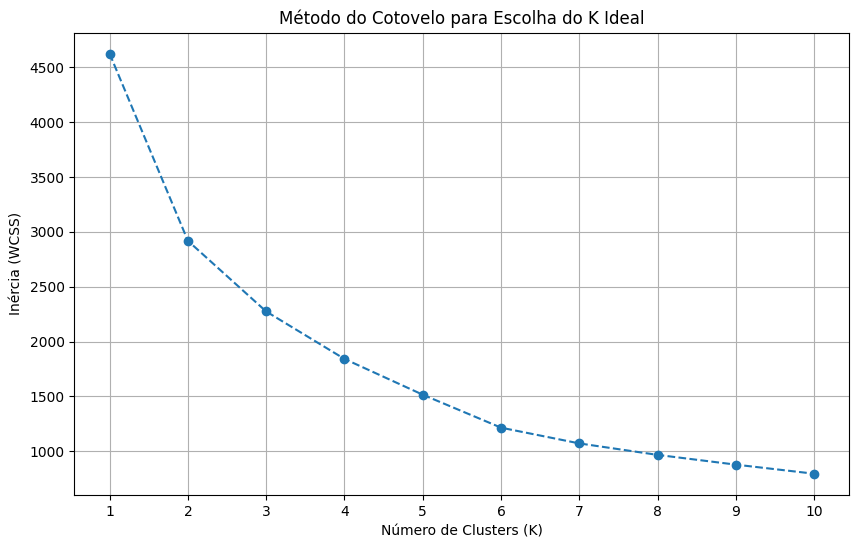

In [41]:
from sklearn.cluster import KMeans

wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_escalado)
    wcss.append(kmeans.inertia_)

# --- PLOTANDO O GRÁFICO ELBOW ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do Cotovelo para Escolha do K Ideal")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [42]:
import matplotlib.pyplot as plt

# --- TREINANDO O MODELO K-MEANS ---

k = 2 # indicado pelo gráfico do cotovelo
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)

# Treinar o modelo...
kmeans.fit(df_escalado)

,n_clusters,2
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [43]:
# Nova coluna com o cluster
df_cluster['cluster'] = kmeans.labels_

print("DataFrame com os clusters atribuídos:")
print(df_cluster.head())

print("\nContagem de conjuntos de anúncio por cluster:")
print(df_cluster['cluster'].value_counts())

DataFrame com os clusters atribuídos:
   gasto  impressoes  numero de cliques       cpc       ctr  cluster
0  19.60        4508              122.0  0.110112  3.948536        1
1  19.53        4532              140.0  0.102251  4.214475        1
2  21.51        2829              157.0  0.119500  6.362672        1
3  21.82        2681              130.0  0.143553  5.669526        1
4  14.65        1751               51.0  0.164607  5.082810        1

Contagem de conjuntos de anúncio por cluster:
cluster
1    715
0    210
Name: count, dtype: int64


In [44]:
# --- ANÁLISE AGRUPAD DAS MÉDIAS ---
cluster_analysis = df_cluster.groupby('cluster').mean(numeric_only=True)

print("Análise dos Clusters (médias por grupo):")
print(cluster_analysis[['gasto', 'impressoes', 'numero de cliques', 'cpc', 'ctr']])

Análise dos Clusters (médias por grupo):
             gasto    impressoes  numero de cliques       cpc       ctr
cluster                                                                
0        24.529714  11234.157143          14.876190  0.584839  0.741976
1        20.363874   3305.654545         110.222378  0.164058  4.662473


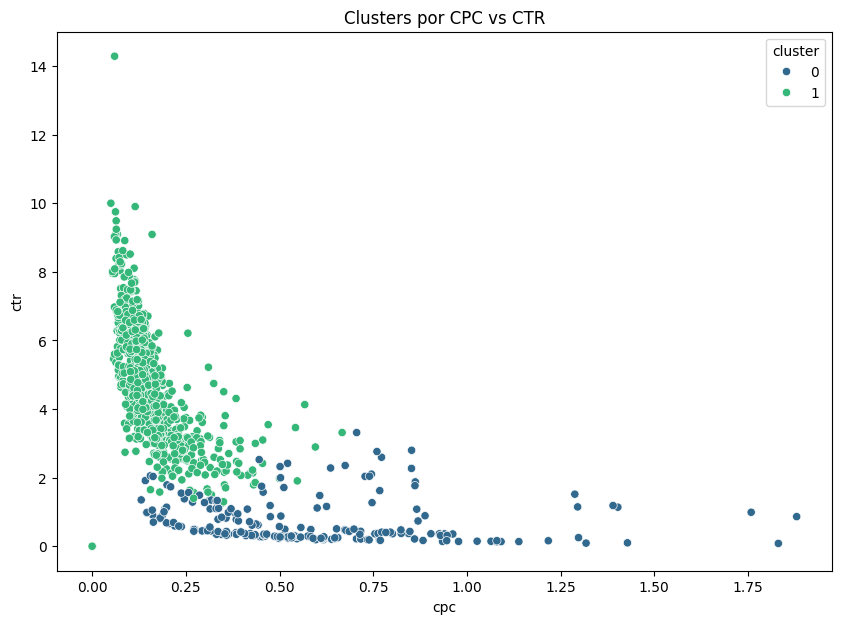

In [46]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_cluster,
    x='cpc',
    y='ctr',
    hue='cluster',
    palette='viridis'
)
plt.title('Clusters por CPC vs CTR')
plt.show()

A análise do **gráfico de dispersão** revela distintamente as características de dois clusters distintos, descobertos pelo algoritmo K-Means:

**Cluster 1: O Grupo de Alta Eficiência**

Este cluster é caracterizado por uma **alta taxa de cliques (CTR)** e um **baixo custo por clique (CPC)**. Representa nosso grupo de **campanhas campeãs em eficiência**. É crucial conduzir uma análise aprofundada desses conjuntos de anúncios para identificar os fatores contribuintes para seu sucesso. Essa investigação pode envolver a avaliação de:

* Chamadas para ação (CTAs) eficazes.
* Formato dos criativos (vídeos, imagens estáticas, carrosséis, etc.).
* Promoções específicas que geraram maior engajamento.
* Textos e cópias persuasivas utilizadas.

Ao compreender esses elementos, será possível replicar as estratégias bem-sucedidas em campanhas futuras, otimizando o retorno sobre o investimento.

**Cluster 0: O Grupo de Baixa Performance**

Em contrapartida, o Cluster 0 exibe uma **baixa taxa de cliques (CTR)** associada a um **custo por clique (CPC) elevado**. Este grupo demanda atenção imediata. As ações recomendadas incluem:

* Monitoramento rigoroso dos criativos para identificar falhas de desempenho.
* Pausar ou desativar anúncios com performance insatisfatória para evitar gastos desnecessários.
* Redistribuir o orçamento para criativos e conjuntos de anúncios que apresentem melhor performance.
* Otimizar os criativos existentes por meio de testes A/B e refinamento de mensagens.

Essas ações visam melhorar a eficácia global das campanhas e garantir que o investimento seja direcionado para as iniciativas mais promissoras.